In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)

basic_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_evaluated.csv')
#GNN_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_GNNRank_reTrained_syncRank_evaluated.csv')
#full_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_fullDataset_evaluated.csv')
#full_GNN_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_GNNRank_fullDataset_evaluated.csv')
#full_df['iteration'] = 500
#full_GNN_df['iteration'] = 500
#raw_df = pd.concat([basic_df, GNN_df, full_df, full_GNN_df])

#raw_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_stratified_evaluated.csv')

raw_df = basic_df
raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})

fairPR_df = raw_df[raw_df['Ranking Method'] == 'fairPageRank'].copy()
fairPR_df = fairPR_df.replace({'fairPageRank': 'Fairness-Aware PageRank (not post-processed)'})
#raw_df = pd.read_csv('./data/post_processing/EPIRA_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/EPIRA99_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/FAstarIR_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/FAstarIRp60_10trials.csv')
raw_df = pd.read_csv('./data/post_processing/IMDB-WIKI_EPIRA99_10trials_v2.csv')

raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})
raw_df = pd.concat([raw_df, fairPR_df])

raw_df

,trial,iteration,value,sampling method,Ranking Method,metric,group,bias_applied
0,0,80,0.207298,randomSampling,davidScore,tau,Overall,True
1,0,80,0.203391,randomSampling,davidScore,tau,Privileged,True
2,0,80,0.206385,randomSampling,davidScore,tau,Unprivileged,True
3,0,80,0.094408,randomSampling,davidScore,exposure,Privileged,True
4,0,80,0.089390,randomSampling,davidScore,exposure,Unprivileged,True
...,...,...,...,...,...,...,...,...
86051,9,1000,0.090021,rankSampling,Fairness-Aware PageRank (not post-processed),exposure,Privileged,True
86052,9,1000,0.094977,rankSampling,Fairness-Aware PageRank (not post-processed),exposure,Unprivileged,True
86053,9,1000,0.310038,rankSampling,Fairness-Aware PageRank (not post-processed),tau,Privileged within-group,True
86054,9,1000,0.402615,rankSampling,Fairness-Aware PageRank (not post-processed),tau,Between groups,True


In [3]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

,iteration,bias_applied,sampling method,metric,group,Ranking Method,trial,value,exposure,tau
0,500,True,oversampling,exposure,Privileged,Fairness-Aware PageRank (not post-processed),4.5,0.090140,0.090140,NaN
1,500,True,oversampling,exposure,Privileged,GNNRank,4.5,0.094565,0.094565,NaN
2,500,True,oversampling,exposure,Privileged,davidScore,4.5,0.091867,0.091867,NaN
3,500,True,oversampling,exposure,Privileged,randomRankRecovery,4.5,0.092308,0.092308,NaN
4,500,True,oversampling,exposure,Privileged,rankCentrality,4.5,0.091944,0.091944,NaN
...,...,...,...,...,...,...,...,...,...,...
115,500,True,rankSampling,tau,Unprivileged within-group,Fairness-Aware PageRank (not post-processed),4.5,0.305092,NaN,0.305092
116,500,True,rankSampling,tau,Unprivileged within-group,GNNRank,4.5,0.242703,NaN,0.242703
117,500,True,rankSampling,tau,Unprivileged within-group,davidScore,4.5,0.225960,NaN,0.225960
118,500,True,rankSampling,tau,Unprivileged within-group,randomRankRecovery,4.5,0.707635,NaN,0.707635


In [4]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

,bias_applied,sampling method,metric,group,Ranking Method,exposure,tau
0,True,oversampling,exposure,Privileged,Fairness-Aware PageRank (not post-processed),0.090140,NaN
1,True,oversampling,exposure,Privileged,GNNRank,0.094565,NaN
2,True,oversampling,exposure,Privileged,davidScore,0.091867,NaN
3,True,oversampling,exposure,Privileged,randomRankRecovery,0.092308,NaN
4,True,oversampling,exposure,Privileged,rankCentrality,0.091944,NaN
20,True,oversampling,tau,Privileged,Fairness-Aware PageRank (not post-processed),NaN,0.294507
21,True,oversampling,tau,Privileged,GNNRank,NaN,0.195763
22,True,oversampling,tau,Privileged,davidScore,NaN,0.170488
23,True,oversampling,tau,Privileged,randomRankRecovery,NaN,0.705392
24,True,oversampling,tau,Privileged,rankCentrality,NaN,0.176849


In [5]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

,bias_applied,sampling method,metric,Ranking Method,exposure_priv,tau_priv,exposure_unpriv,tau_unpriv,exposure ratio,error ratio
0,True,oversampling,exposure,Fairness-Aware PageRank (not post-processed),0.090140,NaN,0.094826,NaN,1.051988,NaN
1,True,oversampling,exposure,GNNRank,0.094565,NaN,0.089189,NaN,0.943142,NaN
2,True,oversampling,exposure,davidScore,0.091867,NaN,0.092626,NaN,1.008258,NaN
3,True,oversampling,exposure,randomRankRecovery,0.092308,NaN,0.092064,NaN,0.997357,NaN
4,True,oversampling,exposure,rankCentrality,0.091944,NaN,0.092528,NaN,1.006354,NaN
5,True,oversampling,tau,Fairness-Aware PageRank (not post-processed),NaN,0.294507,NaN,0.314177,NaN,0.937393
6,True,oversampling,tau,GNNRank,NaN,0.195763,NaN,0.201645,NaN,0.970831
7,True,oversampling,tau,davidScore,NaN,0.170488,NaN,0.170251,NaN,1.001388
8,True,oversampling,tau,randomRankRecovery,NaN,0.705392,NaN,0.705584,NaN,0.999728
9,True,oversampling,tau,rankCentrality,NaN,0.176849,NaN,0.177035,NaN,0.998949


In [6]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

,bias_applied,sampling method,Ranking Method,exposure ratio,error ratio,error
0,True,oversampling,Fairness-Aware PageRank (not post-processed),1.051988,0.937393,0.291074
1,True,oversampling,GNNRank,0.943142,0.970831,0.200748
2,True,oversampling,davidScore,1.008258,1.001388,0.171163
3,True,oversampling,randomRankRecovery,0.997357,0.999728,0.705597
4,True,oversampling,rankCentrality,1.006354,0.998949,0.177741
5,True,randomSampling,Fairness-Aware PageRank (not post-processed),1.054464,0.930761,0.268770
6,True,randomSampling,GNNRank,0.936486,0.964789,0.198767
7,True,randomSampling,davidScore,0.935233,0.962737,0.151806
8,True,randomSampling,randomRankRecovery,1.001031,0.998053,0.707099
9,True,randomSampling,rankCentrality,0.934359,0.959429,0.160118


In [7]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality',
                                 'full dataset': 'Full Dataset'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

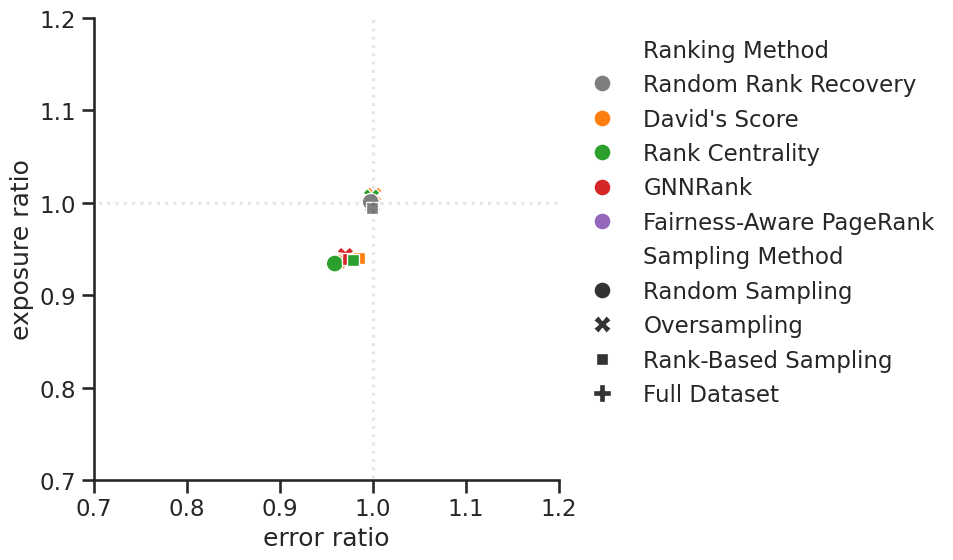

In [8]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling', 'Full Dataset']
df = df[df['Ranking Method'].isin(ranking_methods)]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=ranking_methods,
                         style_order=sampling_methods)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()

## Seperate 1D Plots

In [9]:
sel_df2 = raw_df[(raw_df.iteration == 500) & (raw_df.bias_applied == True)].drop(columns=['iteration', 'bias_applied'])
sel_df2 = sel_df2.pivot(index=['trial', 'sampling method', 'Ranking Method'], columns=['metric', 'group'], values='value').reset_index()
sel_df2

metric trial sampling method                                Ranking Method  \
group                                                                        
0          0    oversampling  Fairness-Aware PageRank (not post-processed)   
1          0    oversampling                                       GNNRank   
2          0    oversampling                                    davidScore   
3          0    oversampling                            randomRankRecovery   
4          0    oversampling                                rankCentrality   
..       ...             ...                                           ...   
145        9    rankSampling  Fairness-Aware PageRank (not post-processed)   
146        9    rankSampling                                       GNNRank   
147        9    rankSampling                                    davidScore   
148        9    rankSampling                            randomRankRecovery   
149        9    rankSampling                                rankCentrality   

metric       tau                           exposure               \
group    Overall Privileged Unprivileged Privileged Unprivileged   
0       0.290254   0.293896     0.312586   0.090153     0.094809   
1       0.206878   0.202962     0.206648   0.094485     0.089291   
2       0.171304   0.170574     0.170724   0.091899     0.092584   
3       0.709447   0.711206     0.706589   0.092199     0.092202   
4       0.177485   0.176539     0.177224   0.091966     0.092500   
..           ...        ...          ...        ...          ...   
145     0.362916   0.369158     0.385850   0.090021     0.094977   
146     0.214286   0.210054     0.214838   0.094621     0.089117   
147     0.209396   0.206592     0.206448   0.094648     0.089083   
148     0.711239   0.709006     0.714972   0.092184     0.092221   
149     0.207777   0.203680     0.207209   0.095014     0.088617   

metric                     tau                                           
group  Privileged within-group Between groups Unprivileged within-group  
0                     0.237380       0.325089                  0.271543  
1                     0.207352       0.200089                  0.225225  
2                     0.172502       0.169323                  0.174868  
3                     0.715332       0.708541                  0.700686  
4                     0.178026       0.175577                  0.182087  
..                         ...            ...                       ...  
145                   0.310038       0.402615                  0.330349  
146                   0.213138       0.208047                  0.234072  
147                   0.215376       0.200740                  0.222734  
148                   0.703442       0.712562                  0.722170  
149                   0.208948       0.200220                  0.226931  

[150 rows x 11 columns]

In [10]:
sel_df3 = sel_df2.copy()
sel_df3['exposure ratio'] = sel_df3['exposure']['Unprivileged'] / sel_df3['exposure']['Privileged']
sel_df3['error ratio'] = sel_df3['tau']['Unprivileged'] / sel_df3['tau']['Privileged']
sel_df3['exposure difference'] = sel_df3['exposure']['Unprivileged'] - sel_df3['exposure']['Privileged']
sel_df3['error difference'] = sel_df3['tau']['Unprivileged'] - sel_df3['tau']['Privileged']
sel_df3['error'] = sel_df3['tau']['Overall']
sel_df3 = sel_df3[['trial', 'sampling method', 'Ranking Method', 'exposure ratio', 'error ratio', 'error', 'error difference', 'exposure difference']].droplevel('group', axis=1)
sel_df3 = sel_df3.replace({'OversampleMinority': 'Oversampling',
                            'oversampling': 'Oversampling',
                            'RankSampling': 'Rank-Based Sampling',
                            'rankSampling': 'Rank-Based Sampling',
                            'RandomSampling': 'Random Sampling',
                            'randomSampling': 'Random Sampling',
                            'fairPageRank': 'Fairness-Aware PageRank',
                            'davidScore': "David's Score",
                            'randomRankRecovery': 'Random Rank Recovery',
                            'rankCentrality': 'Rank Centrality',
                            'full dataset': 'Full Dataset'})

sel_df3 = sel_df3.rename(columns={'sampling method': 'Sampling Method'})
sel_df3

metric,trial,Sampling Method,Ranking Method,exposure ratio,error ratio,error,error difference,exposure difference
0,0,Oversampling,Fairness-Aware PageRank (not post-processed),1.051652,1.063593,0.290254,0.018690,0.004657
1,0,Oversampling,GNNRank,0.945033,1.018160,0.206878,0.003686,-0.005194
2,0,Oversampling,David's Score,1.007453,1.000877,0.171304,0.000150,0.000685
3,0,Oversampling,Random Rank Recovery,1.000029,0.993508,0.709447,-0.004618,0.000003
4,0,Oversampling,Rank Centrality,1.005809,1.003878,0.177485,0.000685,0.000534
...,...,...,...,...,...,...,...,...
145,9,Rank-Based Sampling,Fairness-Aware PageRank (not post-processed),1.055051,1.045214,0.362916,0.016691,0.004956
146,9,Rank-Based Sampling,GNNRank,0.941833,1.022771,0.214286,0.004783,-0.005504
147,9,Rank-Based Sampling,David's Score,0.941203,0.999307,0.209396,-0.000143,-0.005565
148,9,Rank-Based Sampling,Random Rank Recovery,1.000403,1.008414,0.711239,0.005965,0.000037


In [11]:
# Okabe-Ito color palette
lightblue = "#56B4E9"
yellow = "#F0E442"
orange = "#E69F00"
green = "#009E73"
purple = "#CC79A7"
red = "#D55E00"
blue = "#0072B2"
black = "#000000"
#palette = [black, orange, lightblue, green, yellow, blue, red, purple] # original order
palette = [black, orange, lightblue, green, red, purple] # custom order

#palette = sns.color_palette('tab10')
#palette[0] = palette[7]

sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = sel_df3
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank (not post-processed)']
sampling_methods = ['Full Dataset', 'Random Sampling', 'Oversampling', 'Rank-Based Sampling']
metrics = ['exposure difference', 'error difference', 'error']

df = df[df['Ranking Method'].isin(ranking_methods)]
df = df.melt(id_vars=['Sampling Method', 'Ranking Method'], value_vars=['error', 'exposure difference', 'error difference'])

df['metric_order'] = df.metric.map(metrics.index)
df['sampling_order'] = df['Sampling Method'].map(sampling_methods.index)
df['ranking_order'] = df['Ranking Method'].map(list(reversed(ranking_methods)).index)
df = df.sort_values(by=['ranking_order', 'sampling_order', 'metric_order']).drop(columns=['ranking_order', 'sampling_order', 'metric_order'])

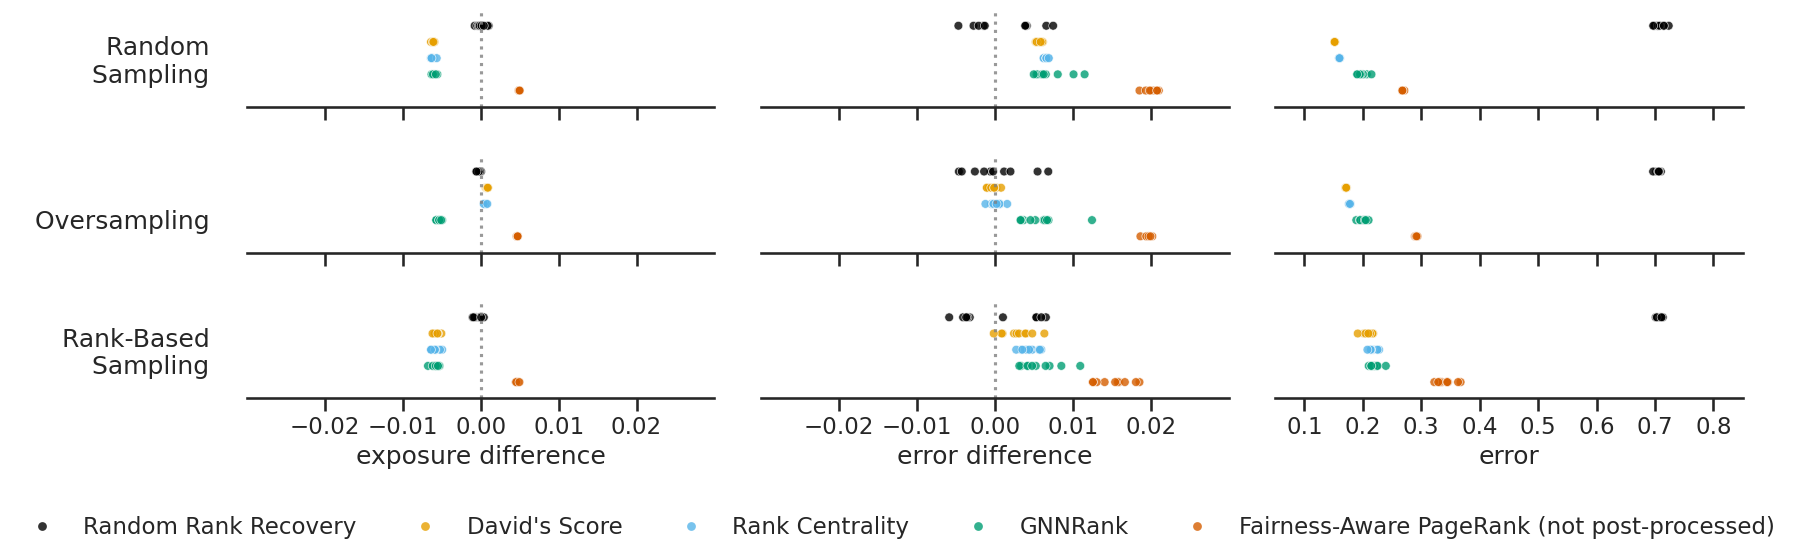

In [12]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.relplot(df, x='value', y='Ranking Method', hue='Ranking Method', kind='scatter', #style='Sampling Method',
                    row='Sampling Method', col='metric',
                    hue_order=ranking_methods, style_order=sampling_methods,
                    s=40, alpha=0.8, aspect=4/1, height=1.8, facet_kws={'sharey': True, 'sharex': False})

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=0, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(-0.03,0.03))
        ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
    
    if col_val == 'exposure difference':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
#plt.savefig('./data/others_results/combined_results_1D.png', dpi=300, bbox_inches="tight")

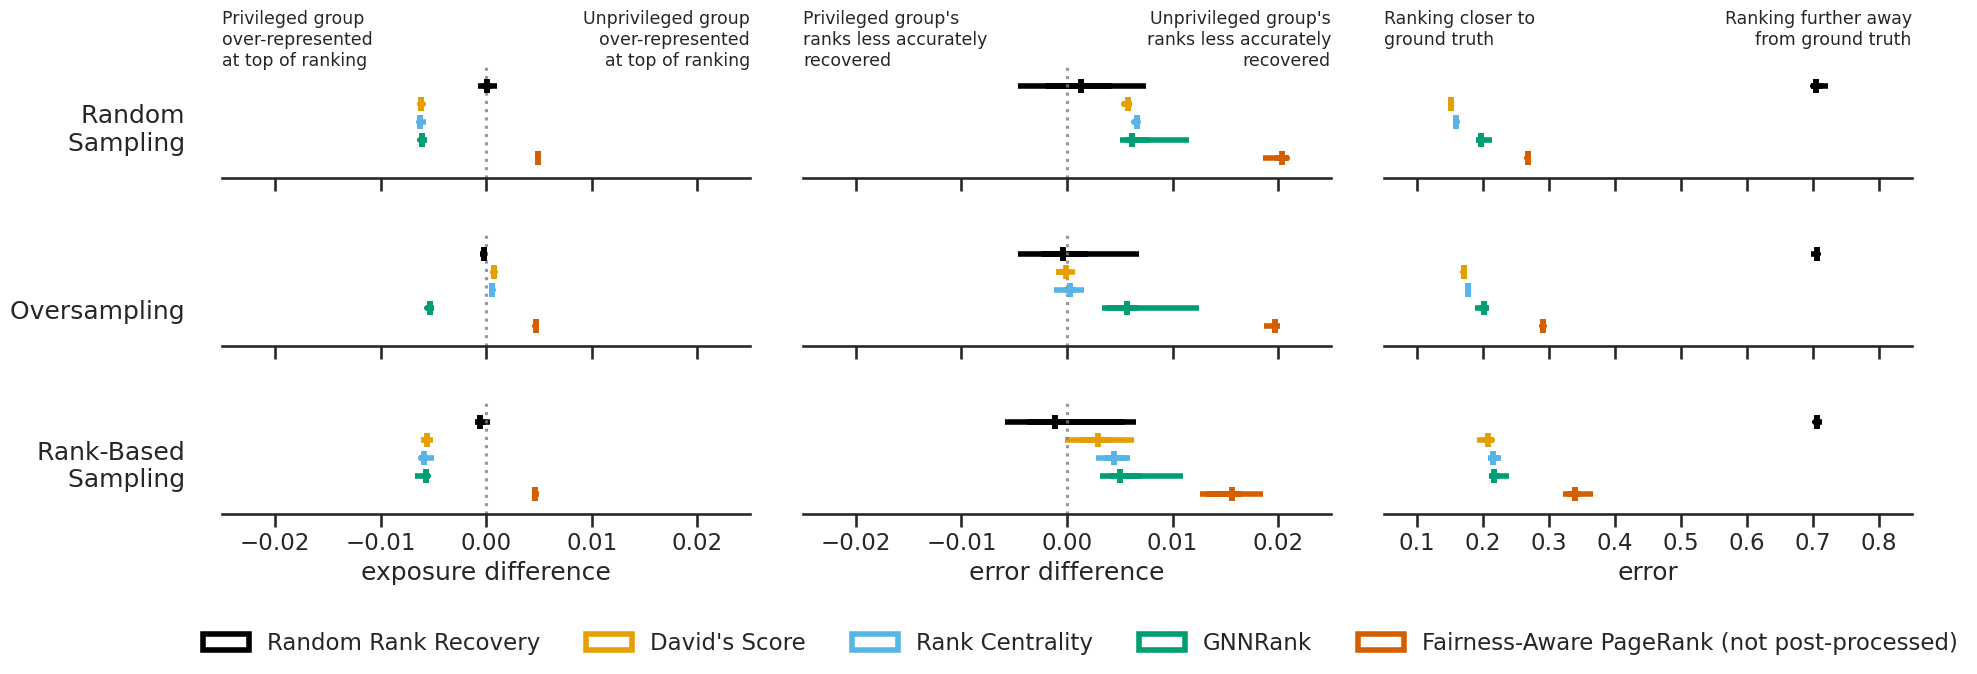

In [13]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.catplot(df, x='value', kind='box', #style='Sampling Method',
                    row='Sampling Method', col='metric', hue='Ranking Method',
                    hue_order=ranking_methods, sharex=False, sharey=True,
                    aspect=3/1, height=2,
                    # sns.boxplot properties
                    fill=False, whis=(0, 100), linewidth=4,
                    # plt.boxplot properties & Line2D properties
                    medianprops={'marker': '|', 'markeredgewidth': 4, 'markersize': 10}, showcaps=False,
                    #showmeans=True, meanprops={'marker': '|', 'markeredgecolor': 'black', 'markeredgewidth': 2, 'markersize': 10},
                    widths=0)
    # s=40, alpha=0.8, facet_kws={'sharey': True, 'sharex': False}, height=1.8

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.008, 0))

g.refline(x=0, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((0.5,-0.5))
    
    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
        #ax.set_xscale('log', base=10)
        pass
    else:
        #log_lim = 0.86
        #log_lim = 0.65
        #ax.set(xlim=(log_lim,1/log_lim))
        #ax.set_xscale('log', base=10)
        #ticks = [.9,.95,1,1.05,1.1,1.15]
        #ticks = [0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
        #ticklabels = [0.7,0.8,0.9,1,'',1.2,'',1.4]
        #ax.set_xticks(ticks)
        #ax.set_xticklabels(ticklabels)
        ax.set(xlim=(-0.025,0.025))
        ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
        #ax.set(xlim=(-0.13,0.13))
        #ax.set_xticks([-0.1,-0.05,0,0.05,0.1])

    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])
    
    if col_val == 'exposure difference':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)
    
    if row_val == 'Random Sampling':
        y = -.5
        y_offset = -.5
        lim = -0.025 #0.65
        inv_lim = 0.025 #1/lim
        if col_val == 'exposure difference':
            ax.annotate('Privileged group\nover-represented\nat top of ranking',
                        xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\nover-represented\nat top of ranking',
                        xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error difference':
            ax.annotate('Privileged group\'s\nranks less accurately\nrecovered',
                        xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\'s\nranks less accurately\nrecovered',
                        xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error':
            ax.annotate('Ranking closer to\nground truth',
                        xy=(0.05, y), xytext=(0.05,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Ranking further away\nfrom ground truth',
                        xy=(.85, y), xytext=(0.85,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')

sns.despine(left=True)
plt.savefig('./data/combined_plots/IMDB-WIKI_EPIRA99_results_fairPR_diff_short.png', dpi=300, bbox_inches="tight")